# Libraries needed

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tag import pos_tag #library used for POS tagging
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chimex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Chimex\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
#Parse CSV file
tweets = pd.read_csv('dataset.csv')
columns = ['label', 'tweet']
tweets[columns].to_csv('tweets.csv', index=False)
tweets = pd.read_csv('tweets.csv')
pd.set_option('display.Chimex_colwidth', None)
tweets.head(5)

,label,tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,0,bihday your majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,0,factsguide: society now #motivation


# Data Exploration

In [32]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 499.5+ KB


In [33]:
#Check for missing values
null_value = tweets.isnull().sum().sum()
print(f'There are {null_value} missing values.')

There are 0 missing values.


In [34]:
# Count the rows based on the label_id column
row_counts = tweets['label'].value_counts()
# Print the count of each label_id
print(row_counts)

0    29720
1     2242
Name: label, dtype: int64


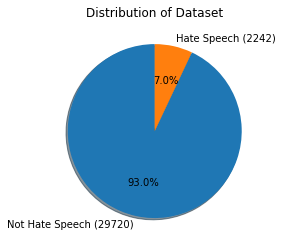

In [35]:
df = pd.DataFrame(tweets)

# Calculate the label counts
label_counts = df['label'].value_counts()

# Prepare the data for the pie chart
labels = ['Not Hate Speech ({})'.format(label_counts[0]), 'Hate Speech ({})'.format(label_counts[1])]
sizes = [label_counts[0], label_counts[1]]

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

# Add a title
ax.set_title("Distribution of Dataset")

# Display the chart
plt.show()


In [36]:
# Extract the text column
text_data = tweets['tweet'].astype(str)

# Concatenate all the text data into a single string
text = ' '.join(text_data)

# Generate word cloud
wordcloud = WordCloud().generate(text)

# Create a plot and display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Data Cleaning and Normalization

In [37]:
#Regex expression, stopword and POS tagging
regex = r'@user|#\w+|[\.!&’?/♂️:,-]|\b\w{1,2}\b|\d+|[^\w\s]+'

# Stopwords
stop_words = set(stopwords.words('english'))

# POS tagging function
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'  # Adjective
    elif treebank_tag.startswith('V'):
        return 'v'  # Verb
    elif treebank_tag.startswith('N'):
        return 'n'  # Noun
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to noun

In [38]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatized_tweet(word):
    word = re.sub(regex, '', word, flags=re.MULTILINE)  # Apply regex
    word = word.lower()  # Convert to lowercase
    tokens = word_tokenize(word)  # Tokenize the text
    tagged_tokens = pos_tag(tokens)  # Perform POS tagging
    lemmatized_tokens = []
    for token, pos in tagged_tokens:
        if token not in stop_words:
            pos_lemma = get_wordnet_pos(pos)
            lemmatized_token = lemmatizer.lemmatize(token, pos=pos_lemma)
            lemmatized_tokens.append(lemmatized_token)
    return " ".join(lemmatized_tokens)
tweets['lemmatized_tweet'] = tweets['tweet'].apply(lemmatized_tweet)
tweets.head(5)

,label,tweet,lemmatized_tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drag kid dysfunction
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks credit use cause offer wheelchair van pdx
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,love take time urð
4,0,factsguide: society now #motivation,factsguide society


In [39]:
# Initialize stemming
stemmer = PorterStemmer()
def stemmed_text(word):
    word = re.sub(regex, '', word, flags=re.MULTILINE) # Apply regex
    word = word.lower() # Convert to lower case
    tokens = word_tokenize(word) # Tokenize the text
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words] # stem the tokens
    return " ".join(tokens)
tweets['stemmed_tweet'] = tweets['tweet'].apply(stemmed_text)
tweets.head(5)

,label,tweet,lemmatized_tweet,stemmed_tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drag kid dysfunction,father dysfunct selfish drag kid dysfunct
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks credit use cause offer wheelchair van pdx,thank credit use caus offer wheelchair van pdx
2,0,bihday your majesty,bihday majesty,bihday majesti
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,love take time urð,love take time urð
4,0,factsguide: society now #motivation,factsguide society,factsguid societi


In [40]:
# Extract the text column
text_data = tweets['stemmed_tweet'].astype(str)

# Concatenate all the text data into a single string
text = ' '.join(text_data)

# Generate word cloud
wordcloud = WordCloud().generate(text)

print("WordCloud Stemmed Tweets")

# Create a plot and display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

WordCloud Stemmed Tweets


In [41]:
# Extract the text column
text_data = tweets['lemmatized_tweet'].astype(str)

# Concatenate all the text data into a single string
text = ' '.join(text_data)

# Generate word cloud
wordcloud = WordCloud().generate(text)

print("WordCloud Lemmatized Tweets")

# Create a plot and display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

WordCloud Lemmatized Tweets


## Data Splitting

In [42]:
#Data Split

# # Split oversampled dataset into train and test sets
# up_train_sm_tweets, up_test_sm_tweets = train_test_split(up_balanced_data, test_size=0.2, random_state=42)

# # Split undersampled dataset into train and test sets
# down_train_sm_tweets, down_test_sm_tweets = train_test_split(down_balanced_data, test_size=0.2, random_state=42)

# Split dataset
train_tweets, test_tweets = train_test_split(tweets, test_size=0.2, random_state=42)

In [43]:
# Count the rows based on the label_id column
row_counts = train_tweets['label'].value_counts()
# Print the count of each label_id
print(row_counts)

0    23783
1     1786
Name: label, dtype: int64


In [44]:
# Count the rows based on the label_id column
row_counts = test_tweets['label'].value_counts()
# Print the count of each label_id
print(row_counts)

0    5937
1     456
Name: label, dtype: int64


## Feature Engineering 

Creation of an NLP Pipeline using B-o-W and TF-IDF text representation techniques 

Adoption of Naive Bayes, Logistic Regression and Support Vector Machine Classifiers

In [45]:
def BOW_pipeline(classifier):
    # Define the pipeline steps
    steps = [
        ('vectorizer', CountVectorizer()),
        ('classifier', classifier)
         ]
    # Create the NLP pipeline
    BOW_nlp_pipeline = Pipeline(steps)
    
    return BOW_nlp_pipeline
# Instantiate the classifiers
NB_BOW = MultinomialNB()
LR_BOW = LogisticRegression()
SVM_BOW = SVC()
RF_BOW = RandomForestClassifier()
DT_BOW = DecisionTreeClassifier()
KNN_BOW = KNeighborsClassifier()
AB_BOW = AdaBoostClassifier()
MLP_BOW = MLPClassifier()        
         
# Create the NLP pipelines for Naive Bayes, SVM and Logistic Regression using BOW text representation
BOW_NB_pipeline = BOW_pipeline(NB_BOW)
BOW_LR_pipeline = BOW_pipeline(LR_BOW)
BOW_SVM_pipeline = BOW_pipeline(SVM_BOW)
BOW_RF_pipeline = BOW_pipeline(RF_BOW)
BOW_DT_pipeline = BOW_pipeline(DT_BOW)
BOW_KNN_pipeline = BOW_pipeline(KNN_BOW)
BOW_AB_pipeline = BOW_pipeline(AB_BOW)
BOW_MLP_pipeline = BOW_pipeline(MLP_BOW)


def TFIDF_pipeline(classifier):
    # Define the pipeline steps
    steps = [
        ('vectorizer', TfidfVectorizer()),
        ('classifier', classifier)
    ]
    # Create the NLP pipeline
    TFIDF_nlp_pipeline = Pipeline(steps)
    
    return TFIDF_nlp_pipeline
# Instantiate the classifiers
NB_TFIDF = MultinomialNB()
LR_TFIDF = LogisticRegression()
SVM_TFIDF = SVC()
RF_TFIDF = RandomForestClassifier()
DT_TFIDF = DecisionTreeClassifier()
KNN_TFIDF = KNeighborsClassifier()
AB_TFIDF = AdaBoostClassifier()
MLP_TFIDF = MLPClassifier()
# Create the NLP pipelines for Naive Bayes, SVM and Logistic Regression using TFIDF text representation
TFIDF_NB_pipeline = TFIDF_pipeline(NB_TFIDF)
TFIDF_LR_pipeline = TFIDF_pipeline(LR_TFIDF)
TFIDF_SVM_pipeline = TFIDF_pipeline(SVM_TFIDF)
TFIDF_RF_pipeline = TFIDF_pipeline(RF_TFIDF)
TFIDF_DT_pipeline = TFIDF_pipeline(DT_TFIDF)
TFIDF_KNN_pipeline = TFIDF_pipeline(KNN_TFIDF)
TFIDF_AB_pipeline = TFIDF_pipeline(AB_TFIDF)
TFIDF_MLP_pipeline = TFIDF_pipeline(MLP_TFIDF)

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5937
           1       0.73      0.32      0.45       456

    accuracy                           0.94      6393
   macro avg       0.84      0.66      0.71      6393
weighted avg       0.93      0.94      0.93      6393

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5937
           1       0.76      0.36      0.49       456

    accuracy                           0.95      6393
   macro avg       0.86      0.67      0.73      6393
weighted avg       0.94      0.95      0.94      6393

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5937
           1       0.88      0.29      0.44       456

    accuracy                           0.95      6393
   macro avg       0.91

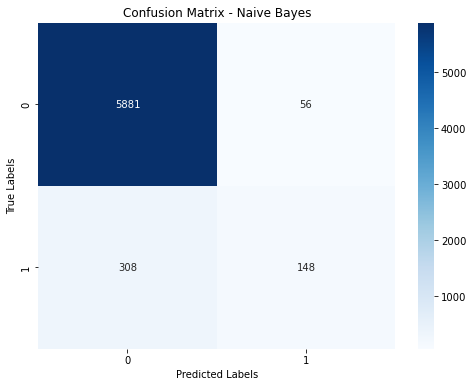

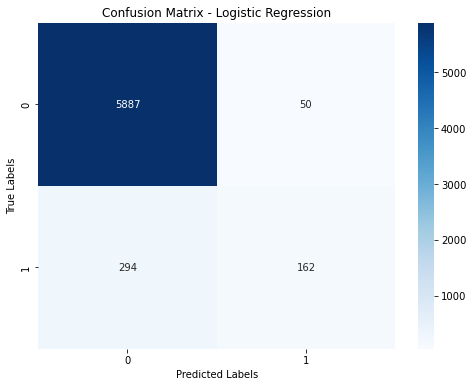

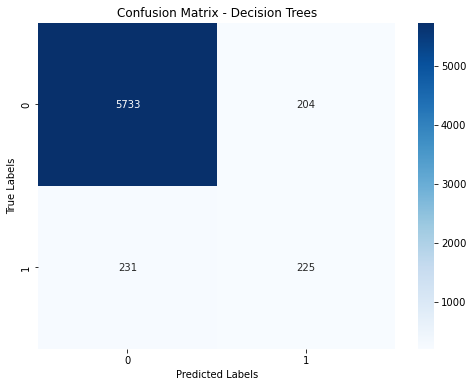

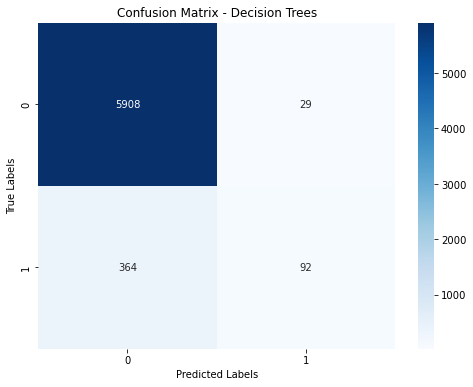

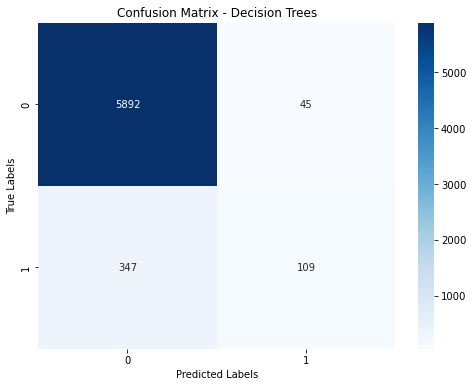

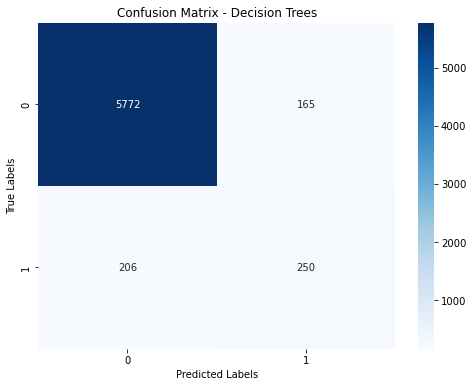

In [46]:
#Naive Bayes
BOW_NB_pipeline.fit(train_tweets['lemmatized_tweet'], train_tweets['label'])#Fit the NB pipeline to training data
LEM_pred_NB = BOW_NB_pipeline.predict(test_tweets['lemmatized_tweet'])#Predict on the test data using Naive Bayes
LEM_accuracy_NB = accuracy_score(test_tweets['label'], LEM_pred_NB)

#Logistic Regression
BOW_LR_pipeline.fit(train_tweets['lemmatized_tweet'], train_tweets['label'])#Fit the LR pipeline on the training data
LEM_pred_LR = BOW_LR_pipeline.predict(test_tweets['lemmatized_tweet']) # Predict on the test data using LR
LEM_accuracy_LR = accuracy_score(test_tweets['label'], LEM_pred_LR)

#SVM
BOW_SVM_pipeline.fit(train_tweets['lemmatized_tweet'], train_tweets['label'])#Fit the SVM pipeline on the training data
LEM_pred_SVM = BOW_SVM_pipeline.predict(test_tweets['lemmatized_tweet'])#Predict on the test data using SVM
LEM_accuracy_SVM = accuracy_score(test_tweets['label'], LEM_pred_SVM)

# Random Forest
BOW_RF_pipeline.fit(train_tweets['lemmatized_tweet'], train_tweets['label'])
LEM_pred_RF = BOW_RF_pipeline.predict(test_tweets['lemmatized_tweet'])
LEM_accuracy_RF = accuracy_score(test_tweets['label'], LEM_pred_RF)

# Decision Trees
BOW_DT_pipeline.fit(train_tweets['lemmatized_tweet'], train_tweets['label'])
LEM_pred_DT = BOW_DT_pipeline.predict(test_tweets['lemmatized_tweet'])
LEM_accuracy_DT = accuracy_score(test_tweets['label'], LEM_pred_DT)

# KNN
BOW_KNN_pipeline.fit(train_tweets['lemmatized_tweet'], train_tweets['label'])
LEM_pred_KNN = BOW_KNN_pipeline.predict(test_tweets['lemmatized_tweet'])
LEM_accuracy_KNN = accuracy_score(test_tweets['label'], LEM_pred_KNN)

# Adaboost
BOW_AB_pipeline.fit(train_tweets['lemmatized_tweet'], train_tweets['label'])
LEM_pred_AB = BOW_AB_pipeline.predict(test_tweets['lemmatized_tweet'])
LEM_accuracy_AB = accuracy_score(test_tweets['label'], LEM_pred_AB)

# MLP
BOW_MLP_pipeline.fit(train_tweets['lemmatized_tweet'], train_tweets['label'])
LEM_pred_MLP = BOW_MLP_pipeline.predict(test_tweets['lemmatized_tweet'])
LEM_accuracy_MLP = accuracy_score(test_tweets['label'], LEM_pred_MLP)

# Calculate precision, recall, and F1 score for Random Forest
report_NB = classification_report(test_tweets['label'], LEM_pred_NB, zero_division=0)
print("Naive Bayes Classification Report:")
print(report_NB)

# Calculate precision, recall, and F1 score for LR
report_LR = classification_report(test_tweets['label'], LEM_pred_LR, zero_division=0)
print("Logistic Regression Classification Report:")
print(report_LR)

# Calculate precision, recall, and F1 score for SVM
report_SVM = classification_report(test_tweets['label'], LEM_pred_SVM, zero_division=0)
print("SVM Classification Report:")
print(report_SVM)

report_RF = classification_report(test_tweets['label'], LEM_pred_RF, zero_division=0)
print("Random Forest Classification Report:")
print(report_RF)

# Calculate precision, recall, and F1 score for Decision Trees
report_DT = classification_report(test_tweets['label'], LEM_pred_DT, zero_division=0)
print("Decision Trees Classification Report:")
print(report_DT)

# Calculate precision, recall, and F1 score for KNN
report_KNN = classification_report(test_tweets['label'], LEM_pred_KNN, zero_division=0)
print("KNN Classification Report:")
print(report_KNN)

# Calculate precision, recall, and F1 score for Adaboost
report_AB = classification_report(test_tweets['label'], LEM_pred_AB, zero_division=0)
print("Adaboost Classification Report:")
print(report_AB)

# Calculate precision, recall, and F1 score for MLP
report_MLP = classification_report(test_tweets['label'], LEM_pred_MLP, zero_division=0)
print("MLP Classification Report:")
print(report_MLP)

# Confusion Matrix

# Naive Bayes
confusion_NB = confusion_matrix(test_tweets['label'], LEM_pred_NB)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_NB, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_NB.png')
plt.show()

# Logistic Regression
confusion_LR = confusion_matrix(test_tweets['label'], LEM_pred_LR)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_LR, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_LR.png')
plt.show()

# SVM
confusion_SVM = confusion_matrix(test_tweets['label'], LEM_pred_SVM)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_SVM, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_SVM.png')
plt.show()

# Random Forest
confusion_RF = confusion_matrix(test_tweets['label'], LEM_pred_RF)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_RF, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_RF.png')
plt.show()

# Decision Trees
confusion_DT = confusion_matrix(test_tweets['label'], LEM_pred_DT)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_DT, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Trees')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_DT.png')
plt.show()

# KNN
confusion_KNN = confusion_matrix(test_tweets['label'], LEM_pred_KNN)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_KNN, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Trees')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_DT.png')
plt.show()

# Adaboost
confusion_AB = confusion_matrix(test_tweets['label'], LEM_pred_AB)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_AB, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Trees')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_DT.png')
plt.show()

# MLP
confusion_MLP = confusion_matrix(test_tweets['label'], LEM_pred_MLP)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_MLP, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Trees')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_DT.png')
plt.show()

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Define your hate speech classifier and its pipeline (e.g., BOW_LR_pipeline)
classifier_pipeline = BOW_LR_pipeline

# Create a function to plot learning curves
def plot_learning_curves(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title('Learning Curves')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Accuracy')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation Accuracy')
    plt.legend(loc='best')
    plt.show()

# Prepare your data (e.g., X and y)
X = train_tweets['lemmatized_tweet']
y = train_tweets['label']

# Plot learning curves
plot_learning_curves(classifier_pipeline, X, y)


In [48]:
# app = dash.Dash(__name__)

import jupyter_dash
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output, State
import numpy as np

app = jupyter_dash.JupyterDash(__name__)

app.layout = html.Div(style={'backgroundColor': '#F2F2F2', 'height': '90vh'}, children=[
    html.H1(style={'text-align': 'center', "color": "white", "paddingTop": "20px", "backgroundColor": "#008080"}, children="Fraud Detection Application"),
    html.Div(style={'display': 'flex', 'flex-direction': 'row', 'width': '50%', 'margin': '20px auto'}, children =[
        html.Div(style={'display': 'flex', 'flex-direction': 'column','width': '47%', 'margin': '0 1.5%'}, children =[
            html.Label("tweet text:"),
            dcc.Input(id="tweet", type="string", value='abc'),
            html.Button("Predict", id="predict-btn"),
            html.Br(),
            html.Label("Prediction:"),
            html.Div(id="prediction-output")
        ]),
    ]),
    html.Div(
            style={
                "position": "absolute",
                "bottom": "0",
                "width": "100%",
                "height": "60px",
                "backgroundColor": "#008080",
                "color": "#fff",
                "textAlign": "center",
                "paddingTop": "20px",
            },
            children=[
                "© 2023 Interactive Dashboard v 1.1. A Data Science Product.",
            ],
        )
])

@app.callback(Output("prediction-output", "children"),
              [Input("predict-btn", "n_clicks")],
              [State("tweet", "value")])
def predict_fraud(n_clicks, tweet):
    input_data = [tweet]
    input_data = np.array(input_data).reshape(1, -1)
    prediction = BOW_SVM_pipeline.predict(input_data)[0]  
    if prediction == 1:
        result = "Hate Speech"
    else:
        result = "Not Hate Speech"
    return result

# if __name__ == "__main__":
#     app.run_server(debug=False, port=8000)
    
if __name__ == "__main__":
    app.run_server(mode='inline', debug=False, port=8000)

Dash is running on http://127.0.0.1:8000/



 * Running on http://127.0.0.1:8000/ (Press CTRL+C to quit)
127.0.0.1 - - [07/Jun/2023 22:01:38] "GET /_alive_cc4a573c-cb94-43f9-927b-fe748882c0dd HTTP/1.1" 200 -


In [50]:
# Problems

# 1. word2vec - achieved
# 2. pipeline that has the preprocessing and text normalisation
# 3. separate pipeline for classifier
# 4. dashboard
# 5. Deep learning
# 6. transfer learning

In [ ]:
#STEP BY STEP

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tag import pos_tag #library used for POS tagging
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import numpy as np
from sklearn.utils import resample

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chimex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Chimex\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [53]:
#Parse CSV file
tweets = pd.read_csv('dataset.csv')
columns = ['label', 'tweet']
tweets[columns].to_csv('tweets.csv', index=False)
tweets = pd.read_csv('tweets.csv')

In [54]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 499.5+ KB


In [55]:
#Regex expression, stopword and POS tagging
regex = r'@user|#\w+|[\.!&’?/♂️:,-]|\b\w{1,2}\b|\d+|[^\w\s]+'

# Stopwords
stop_words = set(stopwords.words('english'))

# POS tagging function
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'  # Adjective
    elif treebank_tag.startswith('V'):
        return 'v'  # Verb
    elif treebank_tag.startswith('N'):
        return 'n'  # Noun
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to noun

In [56]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatized_tweet(word):
    word = re.sub(regex, '', word, flags=re.MULTILINE)  # Apply regex
    word = word.lower()  # Convert to lowercase
    tokens = word_tokenize(word)  # Tokenize the text
    tagged_tokens = pos_tag(tokens)  # Perform POS tagging
    lemmatized_tokens = []
    for token, pos in tagged_tokens:
        if token not in stop_words:
            pos_lemma = get_wordnet_pos(pos)
            lemmatized_token = lemmatizer.lemmatize(token, pos=pos_lemma)
            lemmatized_tokens.append(lemmatized_token)
    return " ".join(lemmatized_tokens)
tweets['lemmatized_tweet'] = tweets['tweet'].apply(lemmatized_tweet)
tweets.head(5)

,label,tweet,lemmatized_tweet
0,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunction
1,0,@user @user thanks for #lyft credit i can't us...,thanks credit use cause offer wheelchair van pdx
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in ...,love take time urð
4,0,factsguide: society now #motivation,factsguide society


In [57]:
# Upsample the dataset based on the "label_name" column
balanced_data = pd.DataFrame()

# Get the class with the Chimeximum count
Chimex_count = tweets['label'].value_counts().Chimex()

# Iterate over each unique label in the dataset
for label in tweets['label'].unique():
    # Get the subset of data for the current label
    subset = tweets[tweets['label'] == label]
    
    # Upsample the minority class to match the count of the majority class
    subset_upsampled = resample(subset, n_samples=Chimex_count, replace=True, random_state=42)
    
    # Concatenate the upsampled subset with the balanced dataset
    balanced_data = pd.concat([balanced_data, subset_upsampled])

# Shuffle the balanced dataset
up_balanced_data = balanced_data.sample(frac=1, random_state=42)

up_balanced_data.head()


,label,tweet,lemmatized_tweet
755,0,#fashionblog rooster simulation: i want to c...,rooster simulation want climb vast expanse mou...
26998,0,@user #beloved gurudev â¥â¥â¥â¥â¥â¥â¥â...,gurudev happy bihdayy love sweeet lordâ
5971,1,this idiot makes my blood boil! #pig #liar,idiot make blood boil
23945,0,#newstar bull up: you will dominate your bul...,bull dominate bull direct whatever want
19684,0,@user #wrist #anyway #liquor #royalty #little_...,father day man shout out


In [58]:
up_balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59440 entries, 755 to 15362
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   label             59440 non-null  int64 
 1   tweet             59440 non-null  object
 2   lemmatized_tweet  59440 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.8+ MB


In [59]:
#Data Split

# Split oversampled dataset into train and test sets
up_train_sm_tweets, up_test_sm_tweets = train_test_split(up_balanced_data, test_size=0.2, random_state=42)

# # Split undersampled dataset into train and test sets
# down_train_sm_tweets, down_test_sm_tweets = train_test_split(down_balanced_data, test_size=0.2, random_state=42)

# Split dataset
train_tweets, test_tweets = train_test_split(tweets, test_size=0.2, random_state=42)

In [66]:
# Split the dataset into training and testing sets
X = tweets['lemmatized_tweet']
y = tweets['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Split the upbalanced dataset into training and testing sets
up_X = up_balanced_data['lemmatized_tweet']
up_y = up_balanced_data['label']
up_X_train, up_X_test, up_y_train, up_y_test = train_test_split(up_X, up_y, test_size=0.2, random_state=42)

# Print the shape of training and testing sets (upsampled)
print("Training set shape:", up_X_train.shape, up_y_train.shape)
print("Testing set shape:", up_X_test.shape, up_y_test.shape)


Training set shape: (25569,) (25569,)
Testing set shape: (6393,) (6393,)
Training set shape: (47552,) (47552,)
Testing set shape: (11888,) (11888,)


In [ ]:
#_-----------------------------------------###############___________________

Tokenization: The text data is tokenized using the Tokenizer class from TensorFlow's Keras API. The fit_on_texts method is used to fit the tokenizer on the training data, which builds the vocabulary based on the unique words in the training data. Then, the texts_to_sequences method is used to convert the text data into sequences of tokens for both the training and testing sets.

Padding: To ensure that all sequences have the same length, the pad_sequences function is used. It pads or truncates the sequences to the defined Chimex_sequence_length, which is set to 100 in this example. The X_train_tokens and X_test_tokens are padded to have a fixed length.

Model Architecture: The model is defined using a sequential API from TensorFlow's Keras. The first layer is an Embedding layer, which maps each token to a dense vector representation. The input_dim is set to the length of the tokenizer's word index plus 1 to account for the out-of-vocabulary (OOV) tokens. The output_dim specifies the dimensionality of the embedding vectors, which is set to 100 in this example. The input_length is set to Chimex_sequence_length.

LSTM Layer: The model includes an LSTM layer with 128 units. LSTM (Long Short-Term Memory) is a type of recurrent neural network layer that can capture long-term dependencies in sequential data.

Dense Layers: The model has a Dense layer with 64 units and a ReLU activation function, followed by a Dropout layer with a rate of 0.3 to prevent overfitting. Another Dense layer with a single unit and a sigmoid activation function is added as the final output layer for binary classification.

Model Compilation: The model is compiled with a binary cross-entropy loss function, which is suitable for binary classification tasks. The adam optimizer is used, and the metric for evaluation is set to accuracy.

Model Training: The model is trained using the fit method. The X_train_padded and y_train are used as input, and the training is performed for 10 epochs with a batch size of 32. The validation_data argument is set to evaluate the model's performance on the validation set during training.

Model Evaluation: After training, the model is used to predict the classes for both the training and testing sets using the predict_classes method. The predicted classes are compared with the actual labels to calculate the accuracy using the accuracy_score function from scikit-learn.

Printing Results: Finally, the train accuracy and test accuracy are printed.

Note: Make sure to replace X_train, X_test, y_train, and y_test with your actual training and testing data.

In [68]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

# # Prepare your data
# X = preprocess_text_data()  # Preprocessed input text data
# y = labels  # Target labels

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tf.random.set_seed(42)
np.random.seed(42)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length
Chimex_sequence_length = 100  # Define the Chimeximum length for padding
X_train_padded = pad_sequences(X_train_tokens, Chimexlen=Chimex_sequence_length)
X_test_padded = pad_sequences(X_test_tokens, Chimexlen=Chimex_sequence_length)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=Chimex_sequence_length),
    tf.keras.layers.LSTM(units=128, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train_padded, y_train, batch_size=32, epochs=10, validation_data=(X_test_padded, y_test), callbacks=[early_stopping])

# Predict on the training and testing sets
y_train_pred_probs = model.predict(X_train_padded)
y_test_pred_probs = model.predict(X_test_padded)

# Convert predicted probabilities to class labels
y_train_pred = [1 if pred > 0.5 else 0 for pred in y_train_pred_probs]
y_test_pred = [1 if pred > 0.5 else 0 for pred in y_test_pred_probs]

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
800/800 [==============================] - 202s 250ms/step - loss: 0.1993 - accuracy: 0.9400 - val_loss: 0.1649 - val_accuracy: 0.9453
Epoch 2/10
800/800 [==============================] - 190s 237ms/step - loss: 0.1071 - accuracy: 0.9647 - val_loss: 0.1683 - val_accuracy: 0.9498
Epoch 3/10
800/800 [==============================] - 176s 220ms/step - loss: 0.0647 - accuracy: 0.9798 - val_loss: 0.2113 - val_accuracy: 0.9492
Epoch 4/10
200/200 [==============================] - 7s 37ms/step
Train Accuracy: 0.9646055770659784
Test Accuracy: 0.9452526200531832


In [69]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)
np.random.seed(42)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length
Chimex_sequence_length = 100  # Define the Chimeximum length for padding
X_train_padded = pad_sequences(X_train_tokens, Chimexlen=Chimex_sequence_length)
X_test_padded = pad_sequences(X_test_tokens, Chimexlen=Chimex_sequence_length)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=Chimex_sequence_length),
    tf.keras.layers.LSTM(units=128, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train_padded, y_train, batch_size=32, epochs=10, validation_data=(X_test_padded, y_test), callbacks=[early_stopping])

# Predict on the training and testing sets
y_train_pred_probs = model.predict(X_train_padded)
y_test_pred_probs = model.predict(X_test_padded)

# Convert predicted probabilities to class labels
y_train_pred = [1 if pred > 0.5 else 0 for pred in y_train_pred_probs]
y_test_pred = [1 if pred > 0.5 else 0 for pred in y_test_pred_probs]

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
800/800 [==============================] - 210s 259ms/step - loss: 0.1990 - accuracy: 0.9400 - val_loss: 0.1654 - val_accuracy: 0.9468
Epoch 2/10
800/800 [==============================] - 206s 258ms/step - loss: 0.1072 - accuracy: 0.9639 - val_loss: 0.1727 - val_accuracy: 0.9507
Epoch 3/10
800/800 [==============================] - 193s 241ms/step - loss: 0.0628 - accuracy: 0.9793 - val_loss: 0.2110 - val_accuracy: 0.9506
Epoch 4/10
200/200 [==============================] - 7s 34ms/step
Train Accuracy: 0.964840236223552
Test Accuracy: 0.9468168309088065


In [72]:
import random
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Set the random seed for reproducibility
random.seed(0.42)
torch.manual_seed(0.42)

# Step 1: Split the dataset
# data = {
#     'label': [0, 0, 0, 0, 0],  # Replace with your actual label column
#     'tweet': ['@user when a father is dysfunctional and is so selfish...',  # Replace with your actual tweet column
#               '@user @user thanks for #lyft credit i can\'t use cause...',
#               'bihday your majesty',
#               '#model i love u take with u all the time in urð±!!!...',
#               'factsguide: society now #motivation'],
#     'lemmatized_tweet': ['father dysfunctional selfish drag kid dysfunction',  # Replace with your actual lemmatized tweet column
#                          'thanks credit use cause offer wheelchair van pdx',
#                          'bihday majesty',
#                          'love take time urð',
#                          'factsguide society'],
#     'stemmed_tweet': ['father dysfunct selfish drag kid dysfunct',  # Replace with your actual stemmed tweet column
#                       'thank credit use caus offer wheelchair van pdx',
#                       'bihday majesti',
#                       'love take time urð',
#                       'factsguid societi']
# }


data = {
    'label': tweets['label'].tolist(),  # Replace 'label' with the actual column name in your dataset
    'tweet': tweets['tweet'].tolist(),  # Replace 'tweet' with the actual column name in your dataset
    'lemmatized_tweet': tweets['lemmatized_tweet'].tolist(),  # Replace 'lemmatized_tweet' with the actual column name in your dataset
}



# Convert data to pandas DataFrame or load your own DataFrame

df = pd.DataFrame(data)

X = df['tweet']  # Replace with your actual text column
y = df['label']  # Replace with your actual label column

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Initialize the tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)



# Step 3: Tokenize and Encode Text Data
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, Chimex_length=128, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, Chimex_length=128, return_tensors='pt')

train_dataset = CustomDataset(train_encodings, list(y_train))
test_dataset = CustomDataset(test_encodings, list(y_test))

# Step 4: Prepare the Input Tensors
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Step 5: Define the Optimizer and Learning Rate Scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Step 6: Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()

for epoch in range(10):
    for batch in train_loader:
        inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)
        
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

# Step 7: Evaluate the Model
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)
        
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_labels = torch.argChimex(logits, dim=1)
        
        predictions.extend(predicted_labels.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

# Calculate accuracy
correct = sum(p == t for p, t in zip(predictions, true_labels))
accuracy = correct / len(predictions)
print("Accuracy:", accuracy)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

KeyboardInterrupt: 

In [ ]:
# to handle the above

In [ ]:
import random
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import logging

# Set the random seed for reproducibility
random.seed(0.42)
torch.manual_seed(0.42)

# Suppress transformers library warning messages
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

# Step 1: Split the dataset
data = {
    'label': tweets['label'].tolist(),  # Replace 'label' with the actual column name in your dataset
    'tweet': tweets['tweet'].tolist(),  # Replace 'tweet' with the actual column name in your dataset
    'lemmatized_tweet': tweets['lemmatized_tweet'].tolist(),  # Replace 'lemmatized_tweet' with the actual column name in your dataset
}

# Convert data to pandas DataFrame or load your own DataFrame
df = pd.DataFrame(data)

X = df['tweet']  # Replace with your actual text column
y = df['label']  # Replace with your actual label column

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Initialize the tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Step 3: Tokenize and Encode Text Data
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).clone().detach()
        return item
    
    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, Chimex_length=128, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, Chimex_length=128, return_tensors='pt')

train_dataset = CustomDataset(train_encodings, list(y_train))
test_dataset = CustomDataset(test_encodings, list(y_test))

# Step 4: Prepare the Input Tensors
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Step 5: Define the Optimizer and Learning Rate Scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Step 6: Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()

for epoch in range(10):
    for batch in train_loader:
        inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)
        
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

# Step 7: Evaluate the Model
model.eval()
predictions = []
true
